In [17]:
import pandas as pd
import statsmodels.formula.api as sm
import numpy as np

df = pd.read_csv('1654342Pet shop.csv')
df.head()

,Unnamed: 0,products_sold,product_category,quality,satisfaction,discount,retail_price,perc_physical,market_size
0,1,82640,toys,off_brand,3.6,11,30.0,76.4,868
1,2,194000,toys,off_brand,4.0,11,15.0,57.1,2625
2,3,148423,food,off_brand,4.5,5,28.0,59.8,974
3,4,201070,toys,off_brand,4.7,2,15.0,33.6,3107
4,5,170240,food,off_brand,4.6,1,NaN,40.7,2384


In [18]:
product_category_dummies = pd.get_dummies(df['product_category'], drop_first=True)
product_quality_dummies = pd.get_dummies(df['quality'])
df_dummies = pd.concat([df,product_category_dummies,product_quality_dummies],axis=1)
df_dummies.head()


,Unnamed: 0,products_sold,product_category,quality,satisfaction,discount,retail_price,perc_physical,market_size,health,other,toys,off_brand,premium
0,1,82640,toys,off_brand,3.6,11,30.0,76.4,868,False,False,True,True,False
1,2,194000,toys,off_brand,4.0,11,15.0,57.1,2625,False,False,True,True,False
2,3,148423,food,off_brand,4.5,5,28.0,59.8,974,False,False,False,True,False
3,4,201070,toys,off_brand,4.7,2,15.0,33.6,3107,False,False,True,True,False
4,5,170240,food,off_brand,4.6,1,NaN,40.7,2384,False,False,False,True,False


In [19]:
# Calculate the number of categories in 'product_category'
category_counts = df['product_category'].value_counts()

category_counts

# I'm chose Food as my reference category because it has the least entries in the dataset. My first assumption will be that it sells the least aswell and that makes the regression model 
# the most interpretable with the numbers

product_category
health    851
toys      832
other     290
food      277
Name: count, dtype: int64

In [20]:
model1 = sm.ols('products_sold ~ health + other + toys + satisfaction + discount + retail_price + perc_physical + market_size + off_brand + premium', data = df_dummies).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:          products_sold   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     720.0
Date:                Tue, 02 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:01:17   Log-Likelihood:                -23395.
No. Observations:                2035   AIC:                         4.681e+04
Df Residuals:                    2024   BIC:                         4.687e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -9.536e+04   5606.08

In [21]:
# Check for missing values in the dataset
missing_values = df_dummies.isnull().sum()
missing_values

Unnamed: 0            0
products_sold         0
product_category      0
quality             111
satisfaction          0
discount              0
retail_price        154
perc_physical        69
market_size           0
health                0
other                 0
toys                  0
off_brand             0
premium               0
dtype: int64

In [22]:
# Dropping the already existing missing values from the dataset. Afterwards we perform CooksD.
df_dummies_nomissingvalues = df_dummies.dropna()


In [23]:
# Before we do CooksD, we will generate another regression model to perform it on without the missing values of the original dataset
model2 = sm.ols('products_sold ~ health + other + toys + satisfaction + discount + retail_price + perc_physical + market_size + off_brand + premium', data = df_dummies_nomissingvalues).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:          products_sold   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     767.4
Date:                Tue, 02 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:01:17   Log-Likelihood:                -22268.
No. Observations:                1937   AIC:                         4.456e+04
Df Residuals:                    1927   BIC:                         4.461e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -6.098e+04   3477.37

In [24]:
# CooksD
CooksD = model2.get_influence().cooks_distance
n = len(df_dummies_nomissingvalues)
df_dummies_nomissingvalues['outlier'] = CooksD[0] > 4/n
df_dummies_nomissingvalues.head()

/tmp/ipykernel_50719/4049309850.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummies_nomissingvalues['outlier'] = CooksD[0] > 4/n


,Unnamed: 0,products_sold,product_category,quality,satisfaction,discount,retail_price,perc_physical,market_size,health,other,toys,off_brand,premium,outlier
0,1,82640,toys,off_brand,3.6,11,30.0,76.4,868,False,False,True,True,False,False
1,2,194000,toys,off_brand,4.0,11,15.0,57.1,2625,False,False,True,True,False,False
2,3,148423,food,off_brand,4.5,5,28.0,59.8,974,False,False,False,True,False,False
3,4,201070,toys,off_brand,4.7,2,15.0,33.6,3107,False,False,True,True,False,False
5,6,219676,other,premium,4.6,7,25.0,44.7,3735,False,True,False,False,True,False


In [25]:
df_dummies_nomissingvalues_true = df_dummies_nomissingvalues[df_dummies_nomissingvalues.outlier == True]
df_dummies_nomissingvalues_false = df_dummies_nomissingvalues[df_dummies_nomissingvalues.outlier == False]

In [26]:
df_dummies_nomissingvalues_true.head()

,Unnamed: 0,products_sold,product_category,quality,satisfaction,discount,retail_price,perc_physical,market_size,health,other,toys,off_brand,premium,outlier
196,197,83364,health,premium,3.0,4,13.0,42.9,2895,True,False,False,False,True,True
237,238,221811,other,off_brand,3.0,16,38.0,26.8,3773,False,True,False,True,False,True
384,385,209891,health,off_brand,4.7,214,15.0,53.1,2840,True,False,False,True,False,True
387,388,224862,toys,premium,4.8,17,29.0,38.5,2100,False,False,True,False,True,True
418,419,57535,other,premium,1.9,10,12.0,5.0,815,False,True,False,False,True,True


In [27]:
print(df_dummies_nomissingvalues[df_dummies_nomissingvalues.outlier == True])

      Unnamed: 0  products_sold product_category    quality  satisfaction  \
196          197          83364           health    premium           3.0   
237          238         221811            other  off_brand           3.0   
384          385         209891           health  off_brand           4.7   
387          388         224862             toys    premium           4.8   
418          419          57535            other    premium           1.9   
...          ...            ...              ...        ...           ...   
2114        2115         218979             food    premium           4.6   
2188        2189          72268            other    premium           4.6   
2190        2191          79891             toys    premium           3.7   
2202        2203         135531             toys  off_brand           4.2   
2211        2212         210145             food    premium           4.0   

      discount  retail_price  perc_physical  market_size  health  other  \


In [28]:
# I analyzed the outliers. There were 60 of them, most of them could not be labeled as impossible. But there were some rows in which the discount weeks or the perc_physical percentage exceeded 52 or 100.
# This is impossible, thus, we will turn every value of those columns above 52 or 100 to a missing value before progressing with the assignment.
# Furthermore, the assignment tells us explicitly to return to the original dataset. So we will be going back at it again with df_dummies.

df_dummies.loc[df_dummies['discount']>52,'discount'] = np.nan
df_dummies.loc[df_dummies['perc_physical']>100,'perc_physical'] = np.nan

In [29]:
# Extra missing values have been added
df_dummies.isnull().sum()

Unnamed: 0            0
products_sold         0
product_category      0
quality             111
satisfaction          0
discount             22
retail_price        154
perc_physical        89
market_size           0
health                0
other                 0
toys                  0
off_brand             0
premium               0
dtype: int64

In [30]:
# To deal with the categorical missing data, we add a dummy missing variable to use in regression models.

df2 = pd.get_dummies(df_dummies, dummy_na=True)

# There were no missing values for product_category. Just to make the dataset as clean as possible we will remove some of the columns which were created through the code above. We only need to keep quality_nan, the rest is redundant.

columns_to_drop = ['product_category_food', 'product_category_health', 'product_category_other', 'product_category_toys', 'quality_off_brand', 'quality_premium', 'product_category_nan']
df2 = df2.drop(columns=columns_to_drop)

df2.head()

,Unnamed: 0,products_sold,satisfaction,discount,retail_price,perc_physical,market_size,health,other,toys,off_brand,premium,quality_nan
0,1,82640,3.6,11.0,30.0,76.4,868,False,False,True,True,False,False
1,2,194000,4.0,11.0,15.0,57.1,2625,False,False,True,True,False,False
2,3,148423,4.5,5.0,28.0,59.8,974,False,False,False,True,False,False
3,4,201070,4.7,2.0,15.0,33.6,3107,False,False,True,True,False,False
4,5,170240,4.6,1.0,NaN,40.7,2384,False,False,False,True,False,False


In [31]:
# For the continouos missing data we impute the data using IterativeImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputed_data = IterativeImputer().fit_transform(df2)
imputed_data = pd.DataFrame(imputed_data, columns=df2.columns)

In [32]:
imputed_data.head()

,Unnamed: 0,products_sold,satisfaction,discount,retail_price,perc_physical,market_size,health,other,toys,off_brand,premium,quality_nan
0,1.0,82640.0,3.6,11.0,30.000000,76.4,868.0,0.0,0.0,1.0,1.0,0.0,0.0
1,2.0,194000.0,4.0,11.0,15.000000,57.1,2625.0,0.0,0.0,1.0,1.0,0.0,0.0
2,3.0,148423.0,4.5,5.0,28.000000,59.8,974.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.0,201070.0,4.7,2.0,15.000000,33.6,3107.0,0.0,0.0,1.0,1.0,0.0,0.0
4,5.0,170240.0,4.6,1.0,20.662371,40.7,2384.0,0.0,0.0,0.0,1.0,0.0,0.0


In [33]:
# We will now check for multicollinearity using scipy.stats

import scipy.stats

import pandas as pd
from scipy.stats import pearsonr

# Select only the numerical columns (excluding dummy variables)
numerical_columns = imputed_data.select_dtypes(include=['int64', 'float64']).columns

# Initialize a DataFrame to hold the Pearson correlation results
pearson_correlations = pd.DataFrame(index=numerical_columns, columns=numerical_columns)

# Calculate Pearson correlation coefficient for each pair of numerical variables
for col1 in numerical_columns:
    for col2 in numerical_columns:
        if col1 != col2:
            # Calculate Pearson's r
            r, _ = pearsonr(imputed_data[col1], imputed_data[col2])
            pearson_correlations.at[col1, col2] = r
        else:
            # A variable's correlation with itself is always 1
            pearson_correlations.at[col1, col2] = 1.0

# Output the correlation matrix
print(pearson_correlations)



              Unnamed: 0 products_sold satisfaction  discount retail_price  \
Unnamed: 0           1.0     -0.029256    -0.034069 -0.015176     0.036158   
products_sold  -0.029256           1.0     0.471275  0.198603    -0.065228   
satisfaction   -0.034069      0.471275          1.0  0.019322    -0.008834   
discount       -0.015176      0.198603     0.019322       1.0     0.004862   
retail_price    0.036158     -0.065228    -0.008834  0.004862          1.0   
perc_physical  -0.031131      0.030741     0.022236  0.006484     0.029216   
market_size    -0.031879      0.708545    -0.005097 -0.020276      0.02811   
health         -0.000994      0.036858     0.033842  0.020035     0.006485   
other           0.002487     -0.026013     -0.02926 -0.007509    -0.030878   
toys           -0.019942     -0.119019    -0.018842 -0.006715    -0.000649   
off_brand      -0.023713      0.100393     0.020285  0.007599     0.028701   
premium         0.018439     -0.104712    -0.016451 -0.003813   

In [34]:
# Checking individual PearsonR results to check the validity of the results from the model above.
SD = scipy.stats.pearsonr(imputed_data['satisfaction'],imputed_data['discount'])
RP_MS = scipy.stats.pearsonr(imputed_data['retail_price'],imputed_data['market_size'])
PP_OB = scipy.stats.pearsonr(imputed_data['perc_physical'],imputed_data['retail_price'])
print(SD)
print(RP_MS)
print(PP_OB)

PearsonRResult(statistic=0.019321743922820593, pvalue=0.35962126685252527)
PearsonRResult(statistic=0.028110247443371095, pvalue=0.1825618212905226)
PearsonRResult(statistic=0.029215873496342366, pvalue=0.165943587130995)


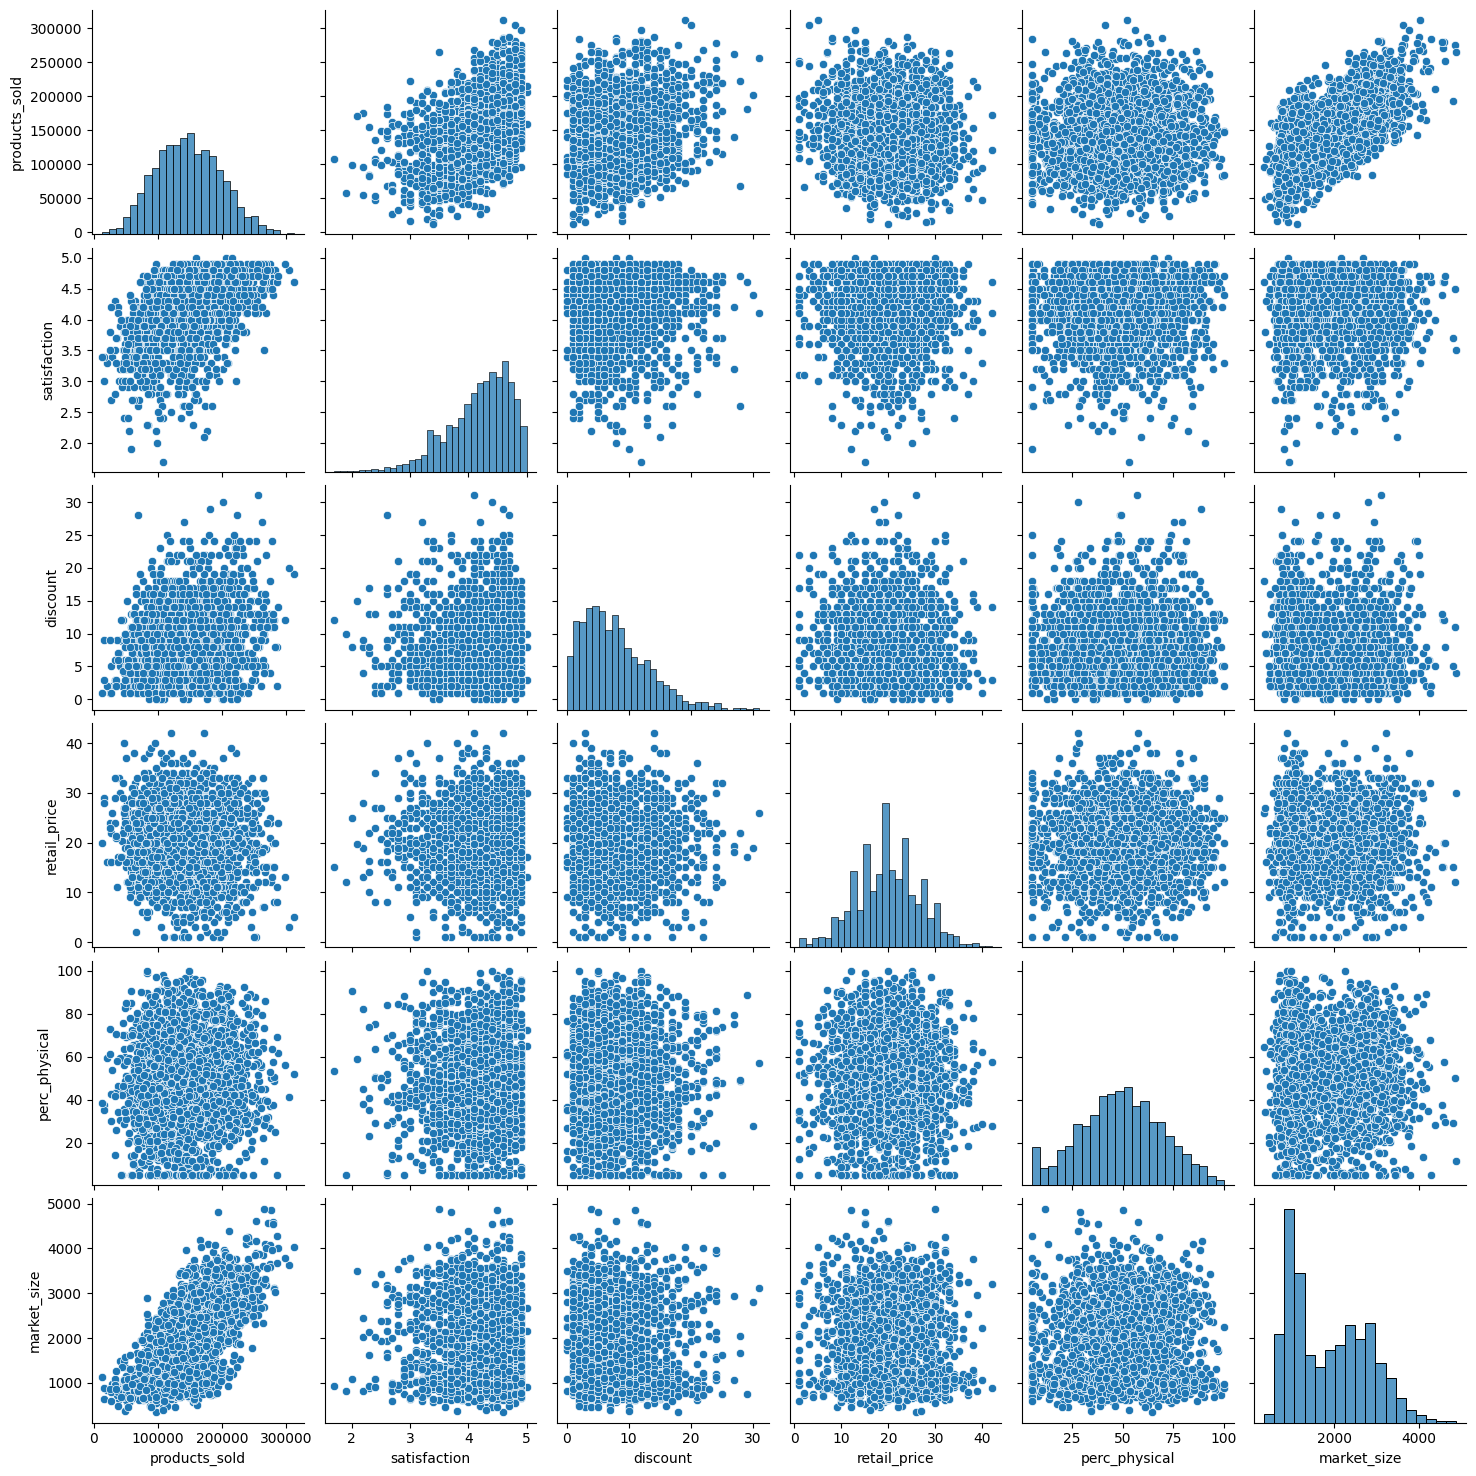

,products_sold,satisfaction,discount,retail_price,perc_physical,market_size
products_sold,1.000000,0.492794,0.165474,-0.048083,0.029670,0.699772
satisfaction,0.492794,1.000000,0.037310,-0.011187,0.021464,-0.005615
discount,0.165474,0.037310,1.000000,0.011391,0.003149,-0.037954
retail_price,-0.048083,-0.011187,0.011391,1.000000,0.026830,0.037391
perc_physical,0.029670,0.021464,0.003149,0.026830,1.000000,0.025142
market_size,0.699772,-0.005615,-0.037954,0.037391,0.025142,1.000000


In [35]:
# The three values to test if the multicollinearity model works perfectly correspond with the values the model gave so we can safely assume the model is correct. 
# There is one multicollinearity problem, off-brand and premium have a 90% correlation.
# Now we will check for non-linear relationships.

import seaborn as sns
import matplotlib.pyplot as plt

# Selecting continuous variables for analysis
continuous_vars = ['products_sold', 'satisfaction', 'discount', 'retail_price', 'perc_physical', 'market_size']

# Plotting scatter plots for each pair of continuous variables
sns.pairplot(imputed_data[continuous_vars])
plt.show()

# Computing Spearman correlation coefficients
spearman_corr = imputed_data[continuous_vars].corr(method='spearman')

spearman_corr


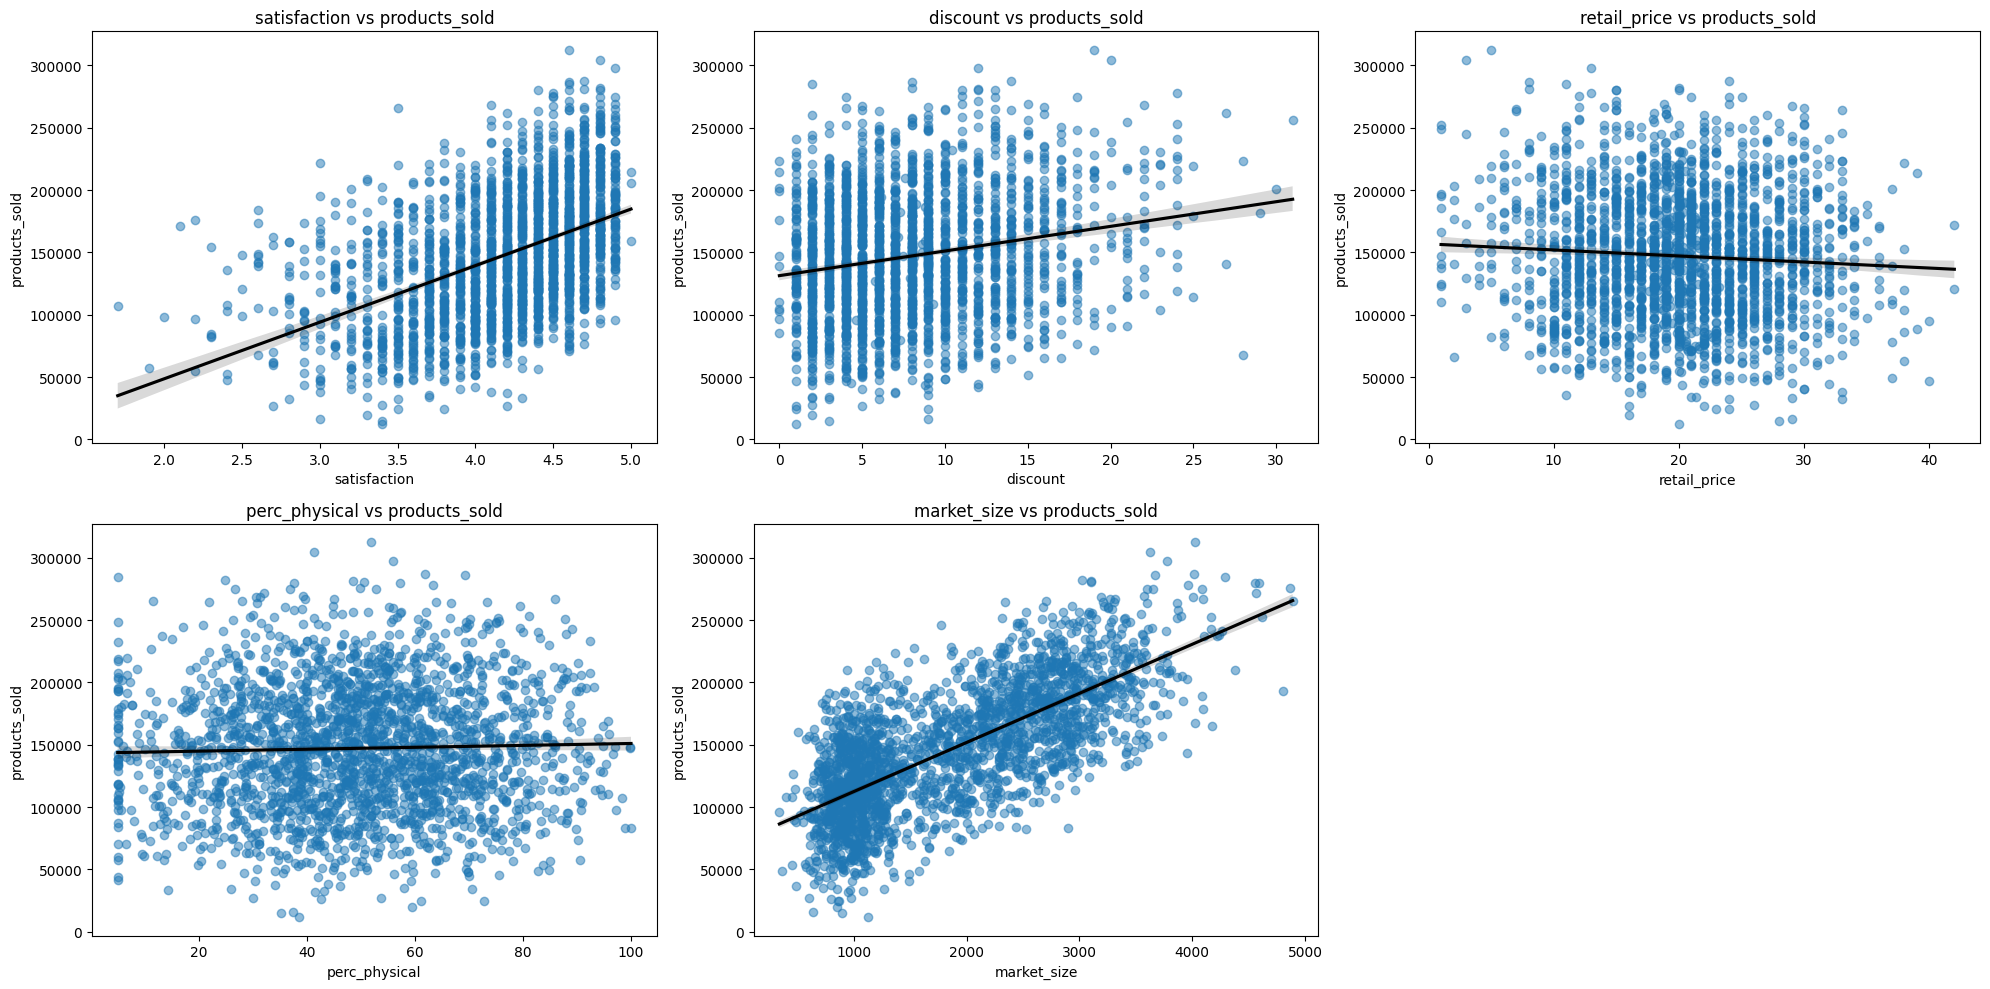

In [36]:
# List of continuous variables, ensuring 'products_sold' is included
continuous_vars = ['products_sold', 'satisfaction', 'discount', 'retail_price', 'perc_physical', 'market_size']

# Removing 'products_sold' from the list for the x-axis variables
x_vars = [var for var in continuous_vars if var != 'products_sold']

# Setting up the figure size for better readability
plt.figure(figsize=(20, 10))

# Iterating over the list of x-axis variables to plot against 'products_sold'
for i, var in enumerate(x_vars):
    plt.subplot(2, 3, i+1)  # Adjusting subplot grid as needed based on the number of x_vars
    sns.regplot(x=var, y='products_sold', data=imputed_data, scatter_kws={"alpha": 0.5}, line_kws={"color":"black"})
    plt.title(f'{var} vs products_sold')

plt.tight_layout()
plt.show()

 

In [37]:
# When looking at the plots with the products_sold on the Y-axis we can conclude that there is no exponential, logarithmic or polynomial relationship.
# Thus we can continue with out dataset for analysis without having to do any transformations.

model_final = sm.ols('products_sold ~ health + other + toys + satisfaction + discount + retail_price + perc_physical + market_size + premium', data = imputed_data).fit()
print(model_final.summary())

# off_brand is not included due to the multicollinearity issues of off_brand and premium

                            OLS Regression Results                            
Dep. Variable:          products_sold   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     1109.
Date:                Tue, 02 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:01:29   Log-Likelihood:                -25653.
No. Observations:                2250   AIC:                         5.133e+04
Df Residuals:                    2240   BIC:                         5.138e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -9.393e+04   4439.896    -21.156

In [38]:
# Health - Significant - Negative impact on sales when a product is in this category
# Other - Significant - Negative impact on sales when a product is in this category
# Toys - Significant - Biggest negative impact on sales when a product is in this category
# Satisfaction - Significant -  Biggest positive impact on sales when satisfaction is higher.
# Discount - Significant - Positive impact on sales. When a product has a discount it sells more.
# Retail Price - Significant - Negative impact on sales when a product has a higher retail price.
# Perc Physical - Insignificant
# Market size - Significant - Positive impact on sales when the market size is bigger.
# Premium - Significant - Negative impact on sales when a product is of a premium brand

### Looking at model_final we see the following

##### both market size and retail price have a significant impact on the sales of the products. where for every unit the retail price goes up the products sells 660 units less and for every increase of a unit market size a product sells 40 units more.

##### Next we will look at the regression models when both variables are the only predictors of products sold and not in combination with other variables.

In [39]:
# Fit the first model and print the summary
model_marketsize = sm.ols('products_sold ~ market_size', data=imputed_data).fit()
print(model_marketsize.summary())

# Add an extra newline for better readability between summaries
print("\n")

# Fit the second model and print the summary
model_retailprice = sm.ols('products_sold ~ retail_price', data=imputed_data).fit()
print(model_retailprice.summary())


                            OLS Regression Results                            
Dep. Variable:          products_sold   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     2266.
Date:                Tue, 02 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:01:29   Log-Likelihood:                -26777.
No. Observations:                2250   AIC:                         5.356e+04
Df Residuals:                    2248   BIC:                         5.357e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    7.322e+04   1725.843     42.425      

#### Analyzing the models in which market size and retail price are the sole predictors

In these models we see a clear difference, not in impact in terms of units sold per shift in unit but especially in R-Squared. We can conclude that market size is responsible for 50.2% of the variance in products sold. 
The R-Squared of retail price is 0.004 and thus only 0.4% of variance in products sold can be explained by the retail price.
This means that we can safely assume that market size has the biggest impact on products sold. Even though the model suggets that the coefficient for retail price is much more impactful, it only explains 0.4% of the variance and thus the market size has more impact on the products sold than the retail price.

In [42]:
new_product = {
    'discount': 20,
    'retail_price': 10,
    'perc_physical': 55,
    'market_size': 1000,
    'health': 0,
    'other': 0,
    'toys': 1,
    'premium': 1,
    'satisfaction': 4.6
}

new_product_df = pd.DataFrame(new_product, index=[0])
new_product_df.head()

,discount,retail_price,perc_physical,market_size,health,other,toys,premium,satisfaction
0,20,10,55,1000,0,0,1,1,4.6


In [44]:
predicted_sales = model_final.predict(new_product_df)
predicted_sales

0    148201.968108
dtype: float64